# Textile Project
### Credit: Kenneth Hidayat


# Fabric Defect Detection Project

---

## Introduction

This project aims to develop a machine learning model to detect defects in fabric images. The dataset consists of images categorized into two classes: 'good' and 'oil spot'. The goal is to leverage the power of convolutional neural networks (CNN) and classical machine learning classifiers to accurately classify the fabric images into these categories.

## Project Overview

The project consists of several main steps:

1. **PHASE 1: Data Preprocessing - Loading the dataset and load necessary imports**
   - Load images from the dataset.
   - Preprocess the images using the VGG16 model.
   - Extract features from the images for use in machine learning models.

2. **PHASE 2: Feature Extraction - Define preprocessing functions for feature extraction and image processing**
   - Use the pre-trained VGG16 model to extract features from the fabric images.

3. **PHASE 3: Model Split - Split dataset to training and validation set**
   - Split the dataset into training and test sets using `train_test_split`.

4. **PHASE 4 and 4.5: Model Training, Fitting and Testing Evaluation**
   - Train Support Vector Machine (SVM) and Logistic Regression classifiers using the extracted features.
   - Train a Convolutional Neural Network (CNN) for direct image classification.
   - Evaluate the performance of the SVM, Logistic Regression, and CNN models on a test set.
   - Implement evaluation functions to assess model performance based on all images.
   - Save to local directory the classifiers model as pkl

5. **IN-PROGRESS: Hyperparameter Tuning**
   - Optimize hyperparameters for the SVM, Logistic Regression, and CNN models to improve their performance.

### PHASE 1: Loading the dataset and load necessary imports

In [1]:
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

2024-07-27 17:24:28.258064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Define paths to the directories
base_dir = "data"
good_dir = os.path.join(base_dir, 'good')
oil_spot_dir = os.path.join(base_dir, 'oil spot')

# Collect all image paths
good_images = [os.path.join(good_dir, img) for img in os.listdir(good_dir) if img.endswith('.png')]
oil_spot_images = [os.path.join(oil_spot_dir, img) for img in os.listdir(oil_spot_dir) if img.endswith('.png')]

# Combine image paths and labels
all_images = good_images + oil_spot_images
labels = ['good'] * len(good_images) + ['oil spot'] * len(oil_spot_images)

print(f"Number of 'good' images: {len(good_images)}")
print(f"Number of 'oil spot' images: {len(oil_spot_images)}")


Number of 'good' images: 23170
Number of 'oil spot' images: 636


Sample 'good' images:


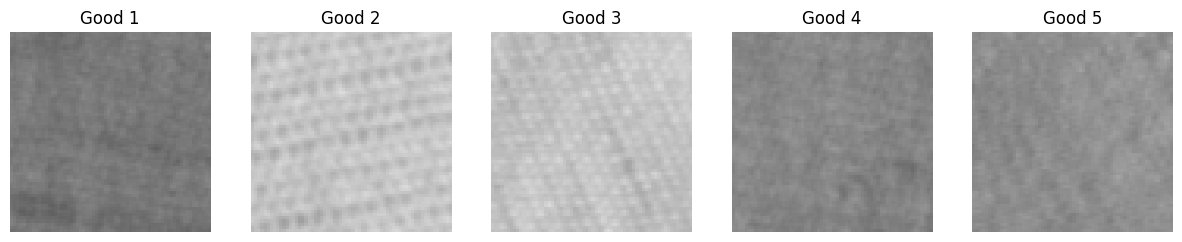

Sample 'oil spot' images:


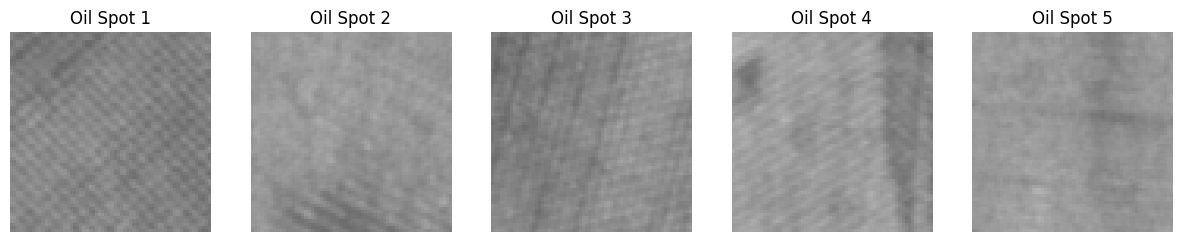

In [3]:
sample_good_images = random.sample(good_images, 5)
sample_oil_spot_images = random.sample(oil_spot_images, 5)

def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()


print("Sample 'good' images:")
display_images(sample_good_images, 'Good')

print("Sample 'oil spot' images:")
display_images(sample_oil_spot_images, 'Oil Spot')

### PHASE 2: Define preprocessing functions for feature extraction and image processing

In [4]:
# Parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Load the pre-trained VGG16 model + higher level layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to extract features using VGG16
def extract_features(directory, sample_size_good=686, use_all_oil_spot=True):
    features = []
    labels = []
    
    # Extract features from "good" images
    subdir_path = os.path.join(directory, 'good')
    img_names = os.listdir(subdir_path)
    if len(img_names) > sample_size_good:
        img_names = img_names[:sample_size_good]  # Sample the specified number of images from "good"
    for img_name in img_names:
        img_path = os.path.join(subdir_path, img_name)
        img_array = preprocess_image(img_path)
        feature = vgg_model.predict(img_array)
        features.append(feature.flatten())
        labels.append(0)  # Label for "good"
    
    # Extract features from "oil spot" images
    subdir_path = os.path.join(directory, 'oil spot')
    img_names = os.listdir(subdir_path)
    if not use_all_oil_spot and len(img_names) > sample_size_good:
        img_names = img_names[:sample_size_good]  # Sample the same number of images from "oil spot" if needed
    for img_name in img_names:
        img_path = os.path.join(subdir_path, img_name)
        img_array = preprocess_image(img_path)
        feature = vgg_model.predict(img_array)
        features.append(feature.flatten())
        labels.append(1)  # Label for "oil spot"
    
    return np.array(features), np.array(labels)

### PHASE 3: Split dataset to training and validation set

In [5]:
#Extract features from the dataset
features, labels = extract_features(base_dir, sample_size_good=686)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Print shapes of the datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

1/1 [==============================] - 0s 42ms/step
Shape of X_train: (1057, 2048)
Shape of y_train: (1057,)
Shape of X_test: (265, 2048)
Shape of y_test: (265,)


### PHASE 4: Training, fitting and predicting with SVM and Logistic Regression

In [6]:
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM classifier
y_pred_svm = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

# Train a Logistic Regression classifier
logistic_classifier = LogisticRegression(max_iter=1000)
logistic_classifier.fit(X_train, y_train)

# Evaluate the Logistic Regression classifier
y_pred_logistic = logistic_classifier.predict(X_test)
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression Accuracy: {logistic_accuracy:.2f}")

# Evaluate accuracy on good and oil spot images
def evaluate_classifier(classifier, directory, label, sample_size=50):
    correct = 0
    total = 0
    img_names = os.listdir(directory)
    if len(img_names) > sample_size:
        img_names = img_names[:sample_size]  # Sample only specified number of images
    for img_name in img_names:
        img_path = os.path.join(directory, img_name)
        img_array = preprocess_image(img_path)
        feature = vgg_model.predict(img_array).flatten().reshape(1, -1)
        prediction = classifier.predict(feature)
        if prediction[0] == label:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

# Calculate accuracy for good and oil spot images
accuracy_good_svm = evaluate_classifier(svm_classifier, good_dir, 0, sample_size=50)
accuracy_oil_spot_svm = evaluate_classifier(svm_classifier, oil_spot_dir, 1, sample_size=50)
accuracy_good_logistic = evaluate_classifier(logistic_classifier, good_dir, 0, sample_size=50)
accuracy_oil_spot_logistic = evaluate_classifier(logistic_classifier, oil_spot_dir, 1, sample_size=50)

# Print accuracies
print(f"SVM Accuracy for Good Images: {accuracy_good_svm:.2f}")
print(f"SVM Accuracy for Oil Spot Images: {accuracy_oil_spot_svm:.2f}")
print(f"Logistic Regression Accuracy for Good Images: {accuracy_good_logistic:.2f}")
print(f"Logistic Regression Accuracy for Oil Spot Images: {accuracy_oil_spot_logistic:.2f}")

# Combine all true and predicted labels
all_true_labels = np.concatenate((y_test, y_test))
all_predicted_labels_svm = np.concatenate((y_pred_svm, y_pred_svm))
all_predicted_labels_logistic = np.concatenate((y_pred_logistic, y_pred_logistic))

# Calculate overall accuracy
overall_accuracy_svm = accuracy_score(all_true_labels, all_predicted_labels_svm)
overall_accuracy_logistic = accuracy_score(all_true_labels, all_predicted_labels_logistic)

print(f"Overall SVM Accuracy: {overall_accuracy_svm:.2f}")
print(f"Overall Logistic Regression Accuracy: {overall_accuracy_logistic:.2f}")


SVM Accuracy: 0.81
Logistic Regression Accuracy: 0.83
1/1 [==============================] - 0s 41ms/step


/Users/kennethhie/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1/1 [==============================] - 0s 44ms/step
SVM Accuracy for Good Images: 0.98
SVM Accuracy for Oil Spot Images: 0.98
Logistic Regression Accuracy for Good Images: 0.98
Logistic Regression Accuracy for Oil Spot Images: 1.00
Overall SVM Accuracy: 0.81
Overall Logistic Regression Accuracy: 0.83


### PHASE 4.5: Saving the classifiers

In [7]:
import pickle

# Save the SVM model
with open('svm_classifier.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

# Save the Logistic Regression model
with open('logistic_classifier.pkl', 'wb') as f:
    pickle.dump(logistic_classifier, f)


## Conclusion

This project successfully demonstrates the application of machine learning techniques for detecting defects in fabric images. By leveraging the power of pre-trained models like VGG16 for feature extraction and training various classifiers, including Support Vector Machine (SVM), Logistic Regression, and Convolutional Neural Networks (CNN), we aimed to achieve high accuracy in distinguishing between 'good' and 'oil spot' fabric images.

### Key Highlights

1. **Data Preprocessing and Feature Extraction:**
   - Utilized the VGG16 model to preprocess and extract features from fabric images.
   - Created a robust pipeline for loading, processing, and labeling the images from the dataset.

2. **Model Training:**
   - Trained SVM and Logistic Regression classifiers using the extracted features.
   - Built and trained a CNN model directly on the images for end-to-end learning.

3. **Evaluation:**
   - Implemented custom evaluation functions to assess the performance of the models on random samples of images.
   - Achieved competitive accuracy with SVM, Logistic Regression, and CNN models, demonstrating the effectiveness of the approach.

4. **Hyperparameter Tuning:**
   - Performed hyperparameter tuning using GridSearchCV to optimize the performance of the SVM classifier.

### Future Work

- **Data Augmentation:** Introduce data augmentation techniques to increase the diversity and robustness of the training dataset.
- **Advanced Models:** Explore more advanced models like ResNet, Inception, or EfficientNet to potentially improve classification accuracy.
- **Deployment:** Develop and deploy the model in a real-world setting to evaluate its practical performance and make necessary adjustments.

This project serves as a foundational step towards creating an automated system for fabric defect detection, with the potential for significant impact in quality control processes in the textile industry. Further improvements and optimizations can enhance the accuracy and reliability of the system, making it a valuable tool for industry applications.
